<a href="https://colab.research.google.com/github/Aravinda89/multi_label_classification/blob/main/Multi_Label_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# ! [ -e /content ] && pip install -Uqq fastai2

In [2]:
!pip install fastai==2.0.19 fastcore==1.3.2

     |████████████████████████████████| 188 kB 11.6 MB/s 
     |████████████████████████████████| 46 kB 4.3 MB/s 
     |████████████████████████████████| 748.8 MB 17 kB/s 
     |████████████████████████████████| 5.9 MB 23.5 MB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.10.0+cu111
    Uninstalling torch-1.10.0+cu111:
      Successfully uninstalled torch-1.10.0+cu111
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.11.1+cu111
    Uninstalling torchvision-0.11.1+cu111:
      Successfully uninstalled torchvision-0.11.1+cu111
  Attempting uninstall: fastai
    Found existing installation: fastai 1.0.61
    Uninstalling fastai-1.0.61:
      Successfully uninstalled fastai-1.0.61
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchtext 0.11.0 requires torch==1.10.0, but you have torch 1.6.0 which is inc

In [3]:
import fastai
print(fastai.__version__)

2.0.19


In [ ]:
# !pip install fastai==2.0.15
# !pip install fastai2==0.0.30
# !pip install fastcore==1.0.16.

# !pip install fastai==2.1.8
# !pip install fastai2==0.0.30
# !pip install fastcore==1.3.26.

In [5]:
# !pip install torch==1.4.0+cu100 torchvision==0.5.0+cu100 -f https://download.pytorch.org/whl/torch_stable.html

In [5]:
from fastai.vision.all import *

import pandas as pd

import torch
from torch import nn

from fastcore.meta import use_kwargs_dict

from fastai.callback.fp16 import to_fp16
from fastai.callback.progress import ProgressCallback
from fastai.callback.schedule import lr_find, fit_one_cycle

from fastai.data.block import MultiCategoryBlock, DataBlock
from fastai.data.external import untar_data, URLs
from fastai.data.transforms import RandomSplitter, ColReader

from fastai.metrics import accuracy_multi, BaseLoss

from fastai.vision.augment import aug_transforms
from fastai.vision.data import ImageBlock
from fastai.vision.learner import cnn_learner

import random

In [6]:
planet_source = untar_data(URLs.PLANET_SAMPLE)

In [7]:
planet_source

Path('/root/.fastai/data/planet_sample')

In [8]:
ls '/root/.fastai/data/planet_sample/train'

train_10001.jpg*  train_19451.jpg*  train_28400.jpg*  train_36771.jpg*
train_10007.jpg*  train_19486.jpg*  train_28414.jpg*  train_36778.jpg*
train_10030.jpg*  train_19510.jpg*  train_28430.jpg*  train_36793.jpg*
train_10033.jpg*  train_19547.jpg*  train_28448.jpg*  train_36828.jpg*
train_10042.jpg*  train_19553.jpg*  train_28466.jpg*  train_36849.jpg*
train_1004.jpg*   train_19558.jpg*  train_28481.jpg*  train_36927.jpg*
train_10075.jpg*  train_19617.jpg*  train_28504.jpg*  train_36946.jpg*
train_10082.jpg*  train_19763.jpg*  train_28510.jpg*  train_36960.jpg*
train_10084.jpg*  train_19861.jpg*  train_28522.jpg*  train_37065.jpg*
train_10098.jpg*  train_19865.jpg*  train_28544.jpg*  train_37076.jpg*
train_10125.jpg*  train_19950.jpg*  train_28549.jpg*  train_37090.jpg*
train_10131.jpg*  train_19954.jpg*  train_28613.jpg*  train_37094.jpg*
train_1022.jpg*   train_20151.jpg*  train_28654.jpg*  train_37107.jpg*
train_10241.jpg*  train_20168.jpg*  train_28662.jpg*  train_37123.jpg*
train_

In [9]:
df = pd.read_csv(planet_source/'labels.csv')

In [10]:
df

,image_name,tags
0,train_21983,partly_cloudy primary
1,train_9516,clear cultivation primary water
2,train_12664,haze primary
3,train_36960,clear primary
4,train_5302,haze primary road
...,...,...
995,train_1876,cloudy
996,train_10311,clear primary road water
997,train_19080,clear primary
998,train_39339,clear primary road


In [11]:
df[df['tags'].apply(lambda x:'blow_down' in x)]

,image_name,tags
105,train_38511,blow_down clear primary road


In [12]:
df.drop(index=105, inplace=True)

In [13]:
df

,image_name,tags
0,train_21983,partly_cloudy primary
1,train_9516,clear cultivation primary water
2,train_12664,haze primary
3,train_36960,clear primary
4,train_5302,haze primary road
...,...,...
995,train_1876,cloudy
996,train_10311,clear primary road water
997,train_19080,clear primary
998,train_39339,clear primary road


train_8789
bare_ground clear primary


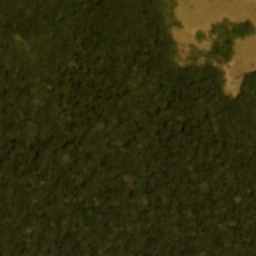

In [14]:
random_index = random.choice(range(len(df['image_name'])))
img_path = df.loc[random_index,'image_name']
img_lbl = df.loc[random_index,'tags']

print(img_path)
print(img_lbl)
im = Image.open('/root/.fastai/data/planet_sample/train/'+img_path+'.jpg').convert('RGB')
im

In [25]:
im.shape

(256, 256)

In [18]:
# DataBlock

In [18]:
batch_tfms = aug_transforms(flip_vert=True, max_lighting=0.1, max_zoom=1.05, max_warp=0.)

In [20]:
planet = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
                   get_x=ColReader(0, pref=f'{planet_source}/train/', suff='.jpg'),
                   splitter=RandomSplitter(),
                   get_y=ColReader(1, label_delim=' '),
                   batch_tfms = batch_tfms)

In [21]:
dls = planet.dataloaders(df)

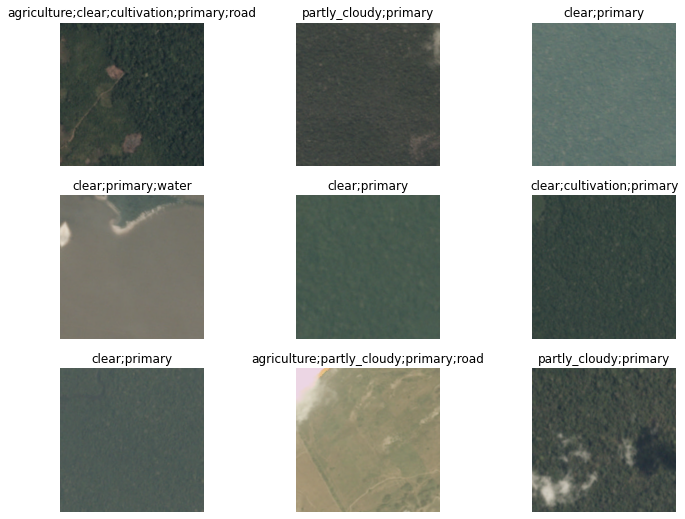

In [28]:
dls.show_batch(max_n=9, figsize=(12,9))

In [30]:
# Lambda

In [40]:
get_x = lambda x:planet_source/'train'/f'{x[0]}.jpg'
get_y = lambda x:x[1].split(' ')

In [42]:
blocks = (ImageBlock, MultiCategoryBlock)

In [43]:
planet = DataBlock(blocks=blocks,
                   get_x=get_x,
                   splitter=RandomSplitter(),
                   get_y=get_y,
                   batch_tfms=batch_tfms)

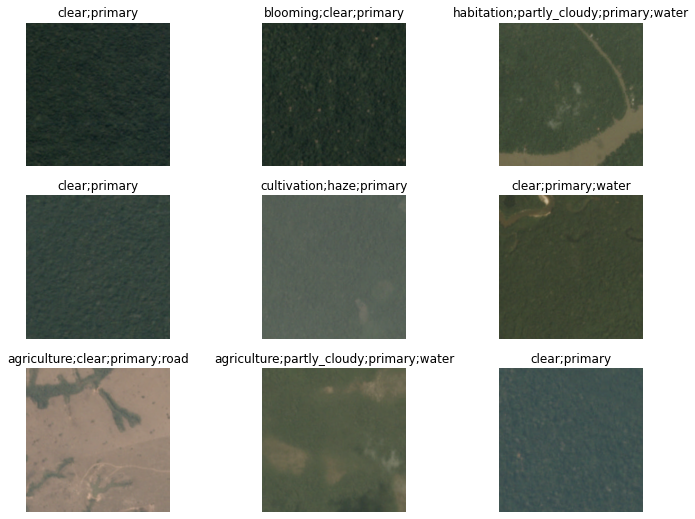

In [45]:
dls = planet.dataloaders(df)
dls.show_batch(max_n=9, figsize=(12,9))

In [ ]:
# get items

In [19]:
def _planet_items(x): 
  return (f'{planet_source}/train/'+x.image_name+'.jpg', x.tags.str.split())

In [20]:
planet = DataBlock.from_columns(blocks=(ImageBlock, MultiCategoryBlock),
                   get_items = _planet_items, 
                   splitter=RandomSplitter(),
                   batch_tfms=batch_tfms)

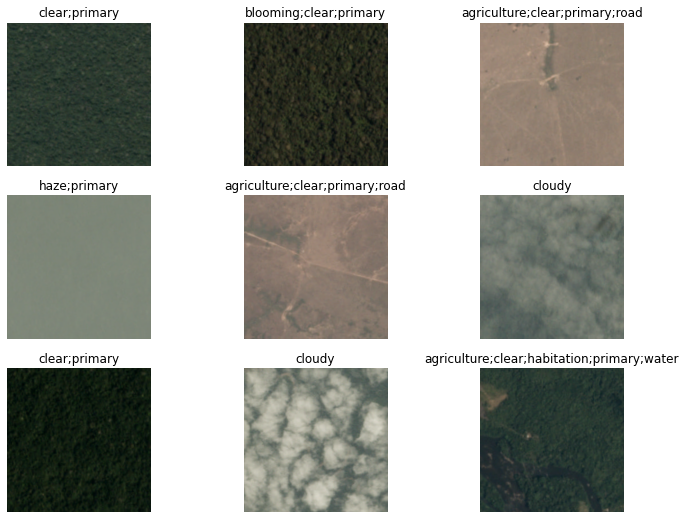

In [21]:
dls = planet.dataloaders(df)
dls.show_batch(max_n=9, figsize=(12,9))

In [ ]:
# Train Model

In [29]:
learn = cnn_learner(dls, resnet18, pretrained=True, metrics=[accuracy_multi])

In [30]:
learn.summary()

Sequential (Input shape: ['64 x 3 x 256 x 256'])
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               64 x 64 x 128 x 128  9,408      False     
________________________________________________________________
BatchNorm2d          64 x 64 x 128 x 128  128        True      
________________________________________________________________
ReLU                 64 x 64 x 128 x 128  0          False     
________________________________________________________________
MaxPool2d            64 x 64 x 64 x 64    0          False     
________________________________________________________________
Conv2d               64 x 64 x 64 x 64    36,864     False     
________________________________________________________________
BatchNorm2d          64 x 64 x 64 x 64    128        True      
________________________________________________________________
ReLU                 64 x 64 x 64 x 64    0          False     
_________________________________________________

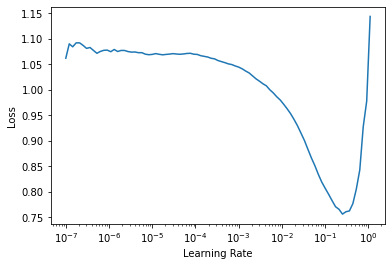

In [31]:
lr_min,lr_steep = learn.lr_find()

In [32]:
print(f"Minimum/10: {lr_min:.2e}, steepest point: {lr_steep:.2e}")

Minimum/10: 2.51e-02, steepest point: 3.31e-02


In [33]:
learn.fit_one_cycle(5, lr_max=2.51e-02, 
                    cbs=[EarlyStoppingCallback(monitor='valid_loss', patience=2),
                        ReduceLROnPlateau(monitor='valid_loss', patience=2)])

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.861684,1.073609,0.589196,00:09
1,0.544014,0.331207,0.910804,00:05
2,0.397236,0.253602,0.922425,00:06
3,0.319818,0.171303,0.942525,00:05
4,0.265363,0.159253,0.942525,00:05


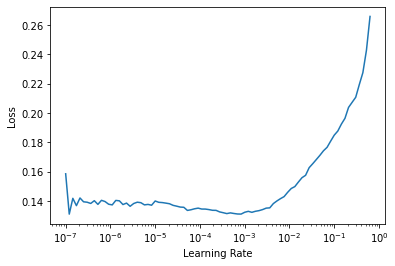

In [35]:
learn.unfreeze()

lr_min,lr_steep = learn.lr_find()

In [36]:
print(f"Minimum/10: {lr_min:.2e}, steepest point: {lr_steep:.2e}")

Minimum/10: 8.32e-05, steepest point: 1.58e-06


In [37]:
learn.fit_one_cycle(20, lr_max=8.32e-05, 
                    cbs=[EarlyStoppingCallback(monitor='valid_loss', patience=2),
                        ReduceLROnPlateau(monitor='valid_loss', patience=2)])

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.133840,0.155896,0.944410,00:08
1,0.131989,0.153662,0.943153,00:07
2,0.129186,0.146217,0.946608,00:07
3,0.129721,0.144138,0.949121,00:07
4,0.127921,0.133719,0.951633,00:07
5,0.124183,0.144147,0.948807,00:07
6,0.121651,0.137188,0.948807,00:07


No improvement since epoch 4: early stopping


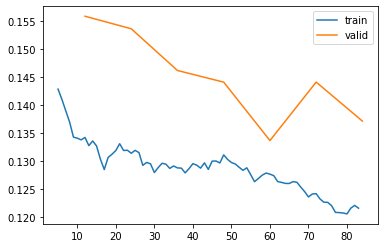

In [41]:
learn.recorder.plot_loss()

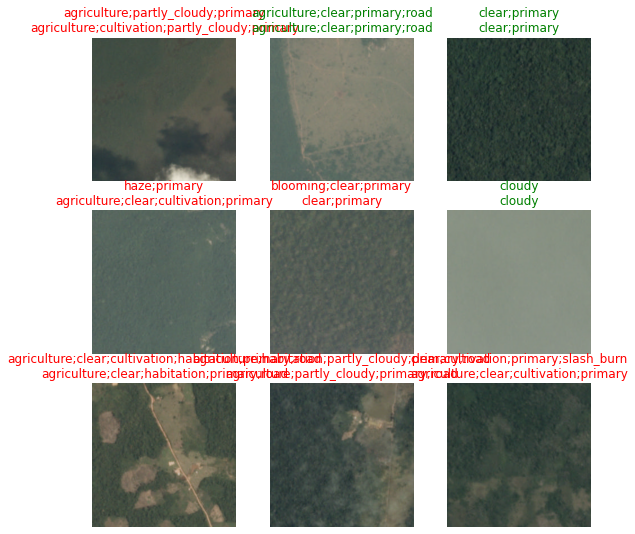

In [43]:
learn.show_results()

In [45]:
interp = ClassificationInterpretation.from_learner(learn)

,target,predicted,probabilities,loss
0,bare_ground;partly_cloudy,agriculture;clear;primary,"tensor([9.3935e-01, 5.0224e-06, 3.0075e-03, 5.2716e-08, 6.1479e-01, 1.5670e-05,\n 1.8658e-05, 6.6056e-02, 1.1124e-02, 2.9186e-04, 3.0010e-01, 9.9933e-01,\n 6.2675e-02, 1.0193e-06, 1.2339e-04, 8.4134e-02])",1.1442561149597168
1,cloudy,clear;primary;water,"tensor([1.0022e-04, 3.5139e-06, 5.3702e-03, 3.1884e-07, 9.9031e-01, 9.3708e-04,\n 1.0855e-06, 4.0538e-04, 1.6832e-04, 4.3440e-03, 1.9434e-05, 7.3712e-01,\n 4.5929e-05, 3.6890e-07, 1.0831e-06, 9.8798e-01])",1.0860826969146729
2,clear;conventional_mine;primary;road,clear;primary;water,"tensor([4.8354e-01, 2.5315e-04, 3.2622e-02, 1.1108e-06, 9.9412e-01, 2.7117e-05,\n 1.9394e-05, 1.0701e-02, 1.0355e-02, 9.0740e-04, 2.5430e-03, 9.9527e-01,\n 5.5887e-02, 1.9618e-05, 1.1991e-03, 8.9694e-01])",1.0461297035217285
3,agriculture;clear;primary;road;water,clear;primary;water,"tensor([5.6678e-03, 3.5968e-03, 1.1460e-01, 2.2295e-07, 9.9748e-01, 1.7256e-04,\n 5.4720e-05, 3.2275e-02, 1.4931e-03, 8.6348e-06, 1.1543e-04, 9.9798e-01,\n 9.1424e-04, 1.7727e-04, 5.1109e-03, 9.9750e-01])",0.7714182734489441
4,habitation;haze;primary;road,agriculture;clear;primary;road,"tensor([8.6901e-01, 8.5321e-05, 3.3786e-03, 1.4980e-05, 9.7816e-01, 3.5160e-06,\n 5.4480e-05, 1.1220e-01, 3.9020e-01, 1.8913e-02, 8.8933e-03, 9.9985e-01,\n 9.8737e-01, 1.1080e-03, 5.9897e-04, 2.0719e-01])",0.6964895725250244


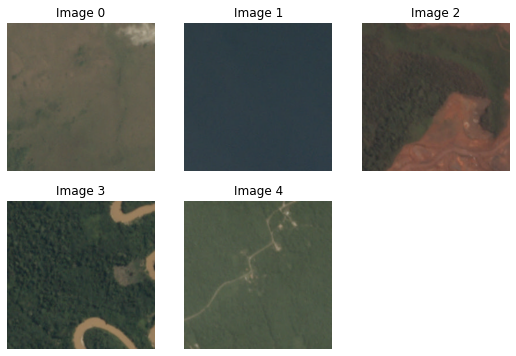

In [47]:
interp.plot_top_losses(k=5)